In [26]:
import os
import nibabel as nib
from nibabel.testing import data_path
import matplotlib
from matplotlib import pyplot as plt
from nilearn import plotting, image
from nilearn.image import mean_img
import numpy as np

from functions import normalize_array, create_volume

In [3]:
# link to fMRI scan
input_fmri_file = "/Users/joachimpfefferkorn/Documents/mri_data/To_Share/T1w_Space/filtreg_sm_dspk_sk_sub-AG5_ses-baseline_task-Newresting1HB6scan_space-T1w_desc-preproc_bold.nii"

In [4]:
andrew_brain_filename = os.path.join(data_path, input_fmri_file)
andrew_brain_img = nib.load(andrew_brain_filename) #why is this a join?

In [5]:
andrew_brain_data = andrew_brain_img.get_fdata()
normalized_brain_array = normalize_array(andrew_brain_data)

In [6]:
normalized_brain_vol = create_volume(normalized_brain_array)

# Comparing to a Base
These results won't be meaningful, but they might be a good MVP of your volume renderer.
Instead of comparing to a control condition, let's just compare to the first 3D volume in the series.
Later you can compare this to something more meaningful.

In [7]:
output_folder = "/Users/joachimpfefferkorn/repos/neurovolume/output/npy_seq"

In [8]:
def view_mid_slice(slice):
    base_slice = slice[:][:][50] #hard coded for now
    plt.imshow(base_slice, cmap="viridis")
    plt.show()


In [35]:
def diff_with_thresh_3D(control, experiment, thresh=0.001):
    diff = np.absolute(control - experiment)
    diff[diff < thresh] = 0
    return diff

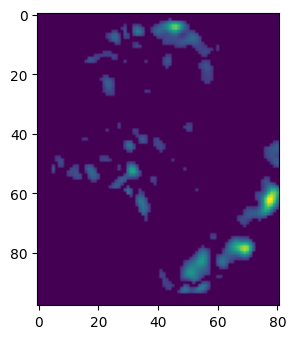

In [37]:
#pulling out the base:
experimental_mid_slice = normalized_brain_vol[:,:,:,200]
control_mid_slice = normalized_brain_vol[:,:,:,0]

diff = diff_with_thresh_3D(control_mid_slice, experimental_mid_slice)
#view_mid_slice(experimental_mid_slice)
#view_mid_slice(control_mid_slice)
view_mid_slice(diff)
#viewing a slice


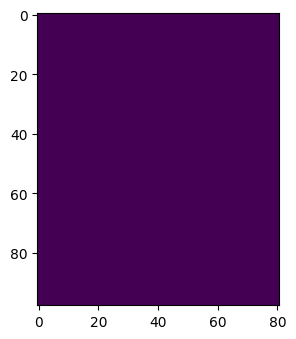

In [38]:
#testing the first frame against itself
#this should be totally blank
experimental_mid_slice = normalized_brain_vol[:,:,:,0]
control_mid_slice = normalized_brain_vol[:,:,:,0]

diff2 = diff_with_thresh_3D(control_mid_slice, experimental_mid_slice)
view_mid_slice(diff2)


In [47]:
diff = diff_with_thresh_3D(control_mid_slice, experimental_mid_slice)


In [48]:
# MVP/Testing CAVEATS (READ BEFORE USING!:
# Not applicable to any kind of meaningful analysis
# only tests against a single, 3D slice as the control.
# Difference is calculated as ABSOLUTE as I don't know how VDBs handle negative numbers
# This probably will have to be a seperate variable:
#   As in, there is the unsigned density (0-1) and then some kind of signed float that represents the activation

# lots of possible x/y/z/row/col gore but hopefully that just results in mirroring of final output.

#gpt rewrite below

def create_4D_volume_MVP(experimental_4D, control_3D_test_variant, output_folder="/Users/joachimpfefferkorn/repos/neurovolume/output/npy_seq"):
    fmri_volume = np.zeros(experimental_4D.shape)
    for time_index in range(experimental_4D.shape[3]):
        # Use the experimental_4D data for the current time slice
        current_slice = experimental_4D[:, :, :, time_index]
        
        # Calculate the density difference
        density = diff_with_thresh_3D(control_3D_test_variant, current_slice)
        
        # Update the fmri_volume with the density values
        fmri_volume[:, :, :, time_index] = density
        
        # Save the current time slice
        vol_frame = "{:03d}".format(time_index)
        np.save(f"{output_folder}/fmri_{vol_frame}.npy", fmri_volume[:, :, :, time_index])
        print(f"saved {vol_frame}")

# Example usage
# create_4D_volume_MVP(experimental_4D, control_3D_test_variant, "/path/to/output_folder")

In [50]:
create_4D_volume_MVP(normalized_brain_vol, normalized_brain_vol[:,:,:,0])

TypeError: create_4D_volume_MVP() missing 1 required positional argument: 'output_folder'

In [49]:
directory = "/Users/joachimpfefferkorn/repos/neurovolume/output/npy_seq"

for index, file in enumerate(sorted(os.listdir("/Users/joachimpfefferkorn/repos/neurovolume/output/npy_seq"))):
    if index%40==0:
        print(index)
        print(file)
        file_path = os.path.join(directory, file)
        tensor = np.load(file_path)
        view_mid_slice(tensor)